In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Input, backend
from tensorflow.keras.models import Model

In [2]:
DATA_PATH_X = 'clean//x-data'
DATA_PATH_Y = 'clean//y-data'
BATCH_SIZE = 16
IMG_SIZE = (100, 100)
EPOCHS = 3

In [ ]:
from PIL import Image
import glob

for infile in glob.glob("*.jpg"):
    im = Image.open(infile)

In [3]:
train_x_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH_X,
    labels=None,
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training")

val_x_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH_X,
    labels=None,
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation")

Found 858 files belonging to 1 classes.
Using 687 files for training.
Found 858 files belonging to 1 classes.
Using 171 files for validation.


In [4]:
train_x_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name=None)>

In [5]:
train_y_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH_Y,
    labels=None,
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training")

val_y_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH_Y,
    labels=None,
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation")

Found 858 files belonging to 1 classes.
Using 687 files for training.
Found 858 files belonging to 1 classes.
Using 171 files for validation.


0 0 1
1 2 3
2 4 5
3 6 7
4 8 9
5 10 11
6 12 13
7 14 15


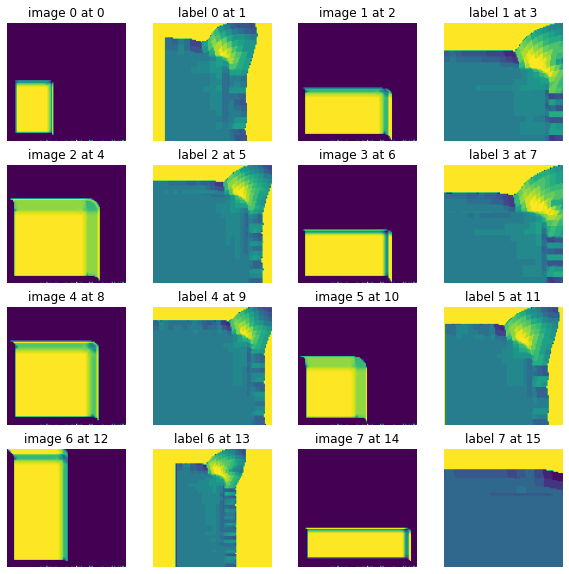

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in zip(train_x_ds.take(1), train_y_ds.take(1)):
  for i in range(8):
    j = 2*i
    k = 2*i+1
    ax = plt.subplot(4, 4, j + 1)
    plt.imshow(images[i])
    plt.title(f"image {i} at {j}")
    plt.axis("off")
    ax = plt.subplot(4, 4, k + 1)
    plt.imshow(labels[i])
    plt.title(f"label {i} at {k}")
    plt.axis("off")

In [6]:
IMG_SIZE[0], IMG_SIZE[1], 1

(36, 36, 1)

In [7]:
model = tf.keras.models.Sequential([
  layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Reshape((4, 4, 1)),
  layers.UpSampling2D(),
#   layers.Conv2DTranspose(64, 3, padding='same', activation='relu'),
#   layers.UpSampling2D(),
  layers.Conv2DTranspose(32, 3, padding='same', activation='relu'),
  layers.UpSampling2D(),
  layers.Conv2DTranspose(16, 3, padding='same', activation='relu'),
  layers.Conv2DTranspose(1, 3, padding='same', activation='relu'),

])

In [7]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [8]:
autoencoder.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  # metrics=tf.keras.metrics.MeanIoU()
  )

In [10]:
type(train_x_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [9]:
autoencoder.fit(
  train_x_ds, train_y_ds,
  validation_data=(val_x_ds, val_x_ds),
  epochs=EPOCHS)

ValueError: `y` argument is not supported when using dataset as input.

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')